Imports & basic setup

In [ ]:
# Cell 2: Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

# Make plots a bit prettier
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)


Download VADER lexicon

In [3]:
# Cell 3: Download VADER lexicon for sentiment analysis (only first time)
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ruham\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Create a small sample review dataset

In [4]:
# Cell 4: Create a synthetic dataset of bank app reviews

data = [
    {"review_text": "Exceptional product, very easy to use and fast.", "rating": 5},
    {"review_text": "The app is impressive and smooth. Great job Dashen Bank!", "rating": 5},
    {"review_text": "Good app but sometimes it is slow.", "rating": 3},
    {"review_text": "Bill payment options are limited, please add more services.", "rating": 2},
    {"review_text": "It is really slow and always crashing. Very frustrating!", "rating": 1},
    {"review_text": "Always updating, bad stability, I don't like it.", "rating": 1},
    {"review_text": "With the super app everything I need is just a tap away.", "rating": 5},
    {"review_text": "It's okay, nothing special but it works.", "rating": 3},
    {"review_text": "I disabled developer options but it still doesn't work.", "rating": 1},
    {"review_text": "Clean design, user friendly and reliable.", "rating": 4},
]

df = pd.DataFrame(data)
df.head()


,review_text,rating
0,"Exceptional product, very easy to use and fast.",5
1,The app is impressive and smooth. Great job Da...,5
2,Good app but sometimes it is slow.,3
3,"Bill payment options are limited, please add m...",2
4,It is really slow and always crashing. Very fr...,1


Map star ratings → sentiment labels (for ML)

In [5]:
# Cell 5: Convert star rating to sentiment label (for supervised ML later)

def rating_to_label(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"

df["sentiment_label"] = df["rating"].apply(rating_to_label)
df


,review_text,rating,sentiment_label
0,"Exceptional product, very easy to use and fast.",5,positive
1,The app is impressive and smooth. Great job Da...,5,positive
2,Good app but sometimes it is slow.,3,neutral
3,"Bill payment options are limited, please add m...",2,negative
4,It is really slow and always crashing. Very fr...,1,negative
5,"Always updating, bad stability, I don't like it.",1,negative
6,With the super app everything I need is just a...,5,positive
7,"It's okay, nothing special but it works.",3,neutral
8,I disabled developer options but it still does...,1,negative
9,"Clean design, user friendly and reliable.",4,positive


1,Frequency-Based vs TF-IDF

Basic text cleaning

In [6]:
# Cell 6: Simple preprocessing (lowercase)
# (You can extend with stopword removal, lemmatization, etc.)

df["clean_text"] = df["review_text"].str.lower()
df[["review_text", "clean_text"]]


,review_text,clean_text
0,"Exceptional product, very easy to use and fast.","exceptional product, very easy to use and fast."
1,The app is impressive and smooth. Great job Da...,the app is impressive and smooth. great job da...
2,Good app but sometimes it is slow.,good app but sometimes it is slow.
3,"Bill payment options are limited, please add m...","bill payment options are limited, please add m..."
4,It is really slow and always crashing. Very fr...,it is really slow and always crashing. very fr...
5,"Always updating, bad stability, I don't like it.","always updating, bad stability, i don't like it."
6,With the super app everything I need is just a...,with the super app everything i need is just a...
7,"It's okay, nothing special but it works.","it's okay, nothing special but it works."
8,I disabled developer options but it still does...,i disabled developer options but it still does...
9,"Clean design, user friendly and reliable.","clean design, user friendly and reliable."


Frequency-based representation (Bag of Words)

In [7]:
# Cell 7: Frequency-based word counts using CountVectorizer

count_vec = CountVectorizer(stop_words="english")
X_counts = count_vec.fit_transform(df["clean_text"])

# Sum counts for each word across all documents
word_counts = np.asarray(X_counts.sum(axis=0)).flatten()
vocab = np.array(count_vec.get_feature_names_out())

freq_df = pd.DataFrame({"word": vocab, "count": word_counts})
freq_df = freq_df.sort_values("count", ascending=False)
freq_df.head(10)


,word,count
1,app,3
27,options,2
33,slow,2
0,add,1
4,bank,1
5,clean,1
6,crashing,1
7,dashen,1
8,design,1
9,developer,1


Visualize top frequent words

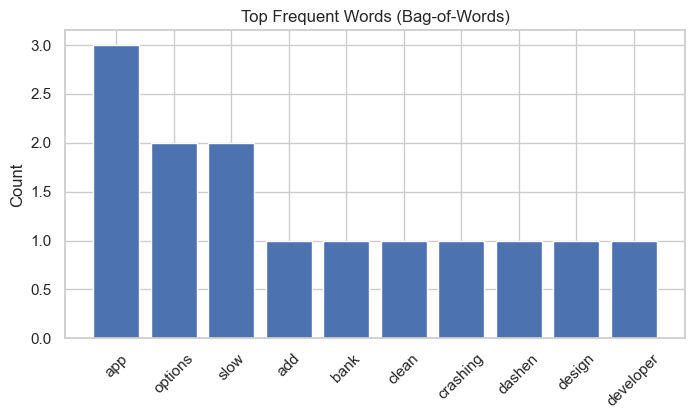

In [8]:
# Cell 8: Plot top frequent words (Frequency-Based)

top_n = 10
top_freq = freq_df.head(top_n)

plt.bar(top_freq["word"], top_freq["count"])
plt.xticks(rotation=45)
plt.title("Top Frequent Words (Bag-of-Words)")
plt.ylabel("Count")
plt.show()


TF-IDF representation

In [9]:
# Cell 9: TF-IDF representation

tfidf_vec = TfidfVectorizer(stop_words="english")
X_tfidf = tfidf_vec.fit_transform(df["clean_text"])

# Get average TF-IDF score per word across documents
tfidf_means = np.asarray(X_tfidf.mean(axis=0)).flatten()
vocab_tfidf = np.array(tfidf_vec.get_feature_names_out())

tfidf_df = pd.DataFrame({"word": vocab_tfidf, "tfidf": tfidf_means})
tfidf_df = tfidf_df.sort_values("tfidf", ascending=False)
tfidf_df.head(10)


,word,tfidf
1,app,0.109914
33,slow,0.100410
27,options,0.078235
18,good,0.066288
26,okay,0.057735
35,special,0.057735
43,works,0.057735
30,really,0.051829
17,frustrating,0.051829
6,crashing,0.051829


TF-IDF (Very Brief Explanation)

TF-IDF shows how important a word is in the dataset.

TF (Term Frequency): how often a word appears.

IDF (Inverse Document Frequency): how unique the word is across all reviews.

TF-IDF = TF × IDF

Higher TF-IDF = more meaningful word.
Lower TF-IDF = common or unimportant word.

✔ What is a good TF-IDF number?

No universal scale — it’s relative.
But generally in small datasets:

> 0.10 = very important

0.05–0.10 = meaningful

< 0.05 = low importance

 Interpretation of our output

“app” (0.1099) → highly important theme

“slow”, “crashing”, “frustrating” → key negative issues

“options”, “good”, “works” → meaningful topics in reviews

In [10]:
# Cell 10: Compare top words by frequency and by TF-IDF

print("Top 10 by raw frequency:")
display(freq_df.head(10))

print("\nTop 10 by TF-IDF (words more unique / informative):")
display(tfidf_df.head(10))


Top 10 by raw frequency:


,word,count
1,app,3
27,options,2
33,slow,2
0,add,1
4,bank,1
5,clean,1
6,crashing,1
7,dashen,1
8,design,1
9,developer,1



Top 10 by TF-IDF (words more unique / informative):


,word,tfidf
1,app,0.109914
33,slow,0.100410
27,options,0.078235
18,good,0.066288
26,okay,0.057735
35,special,0.057735
43,works,0.057735
30,really,0.051829
17,frustrating,0.051829
6,crashing,0.051829


Topic Modeling (LDA)

In [2]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

# Tokenize text (very simple split for demo)
df["tokens"] = df["clean_text"].str.split()

# Create dictionary and corpus for LDA
dictionary = Dictionary(df["tokens"])
corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens"]]

ModuleNotFoundError: No module named 'gensim'